In [39]:
import pandas as pd
import numpy as np

# US or AG
COUNTRY = 'mexico'
# corn, soybean, wheat, sunflower
CROP_TYPE = 'beans_rainfed'  # Default is corn, can be changed to 'soybean' or 'wheat'

VALID_CROP_TYPES = {
    'usa': ['corn', 'soybean', 'winter_wheat'],
    'argentina': ['wheat', 'soybean', 'corn', 'sunflower'],
    "brazil": ["corn", "soybean", "sugarcane", "cotton", "wheat"],
    "mexico": ["corn", "beans", "sugarcane", "wheat", "corn_rainfed", "beans_rainfed"]
}

if CROP_TYPE not in VALID_CROP_TYPES[COUNTRY]:
    raise ValueError(f"Invalid crop type: {CROP_TYPE}. Valid crop types are: {VALID_CROP_TYPES[COUNTRY]}")


US_DATASET_FILE = '../data/khaki_soybeans/khaki_multi_crop_yield.csv'
OTHER_DATASET_FILE = f'../data/khaki_soybeans/khaki_{COUNTRY}_multi_crop.csv'

DATASET_FILE = US_DATASET_FILE if COUNTRY == 'usa' else OTHER_DATASET_FILE


In [40]:
# Load the dataset
crop_yield_col = f"{CROP_TYPE}_yield"
df = pd.read_csv(DATASET_FILE, usecols=["year", "loc_ID", "State", crop_yield_col])

if COUNTRY == "brazil":
    df = df[
            df["State"].isin(["Goiás", "Mato Grosso", "Mato Grosso do Sul", "Paraná", "Rio Grande do Sul"])
        ].copy()

df = df.dropna()
print("Total records: ", len(df))

# Get average yield by year
yearly_yields = df.groupby('year')[crop_yield_col].mean().reset_index()
yearly_yields = yearly_yields.sort_values('year')
yearly_yields.head()

Total records:  23896


,year,beans_rainfed_yield
0,2003,594.924242
1,2004,600.257634
2,2005,551.583665
3,2006,608.278765
4,2007,598.995305


In [41]:
# Compute rolling mean and std for 5 years BEFORE current year
yearly_yields['rolling_mean'] = yearly_yields[crop_yield_col].shift(1).rolling(window=5, min_periods=5).mean()
yearly_yields['rolling_std'] = yearly_yields[crop_yield_col].shift(1).rolling(window=5, min_periods=5).std()
yearly_yields['z_score'] = (yearly_yields[crop_yield_col] - yearly_yields['rolling_mean']) / yearly_yields['rolling_std']
yearly_yields['abs_z_score'] = yearly_yields['z_score'].abs()

# Filter for 2000-2018 and sort by abs_z_score
result = yearly_yields[(yearly_yields['year'] > 2012) & (yearly_yields['year'] <= 2025)].dropna()
result = result.sort_values('abs_z_score', ascending=False)

result.head(5).sort_values('year', ascending=True)


,year,beans_rainfed_yield,rolling_mean,rolling_std,z_score,abs_z_score
10,2013,659.991158,621.365597,25.755236,1.499717,1.499717
11,2014,670.212389,622.840638,28.097148,1.685999,1.685999
14,2017,709.937500,663.392382,16.973278,2.742259,2.742259
15,2018,715.257919,677.340206,21.261149,1.783427,1.783427
18,2021,732.710363,698.960683,12.820027,2.632575,2.632575


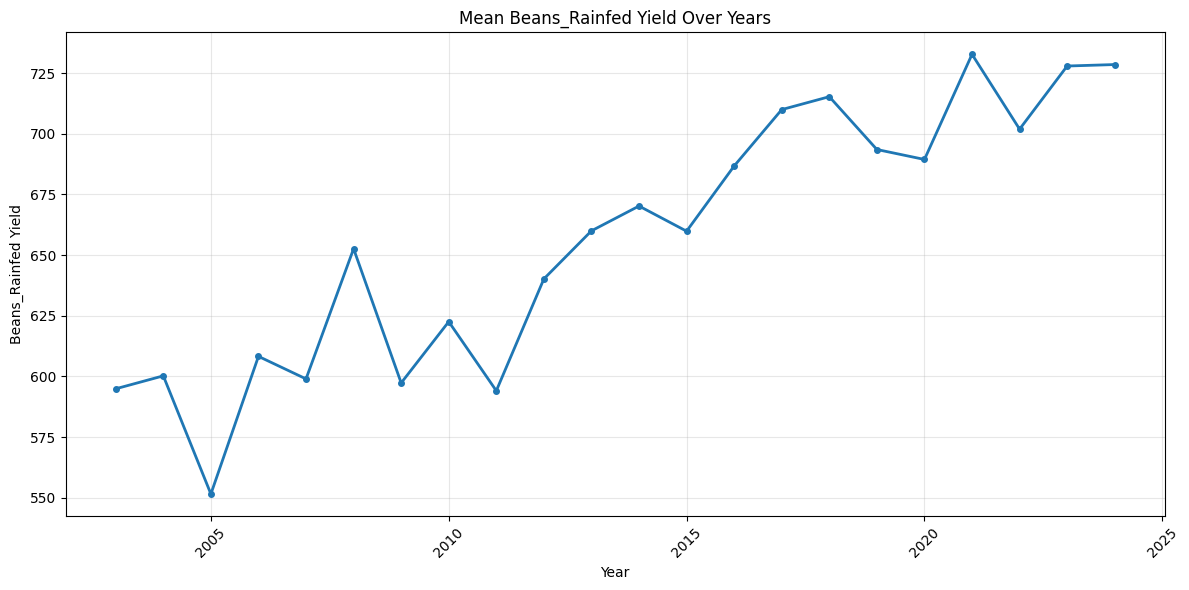

In [42]:
# Plot mean yield over the years
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(yearly_yields['year'], yearly_yields[crop_yield_col], marker='o', linewidth=2, markersize=4)
plt.title(f'Mean {CROP_TYPE.title()} Yield Over Years')
plt.xlabel('Year')
plt.ylabel(f'{CROP_TYPE.title()} Yield')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
